In [415]:
import os
import scipy.stats as stats
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import datetime as dt
import pytz
from sklearn.utils import resample
%matplotlib inline
import warnings

warnings.filterwarnings('ignore')
Root = 'C:/FishIsland_2017/'


FluxFolder='FluxResults/ProperWindSpeeds/'

TenHz_Path = Root+FluxFolder+'10Hz/eddypro_10Hz_full_output_2018-03-25T172145_adv.csv'
OneHz_Path = Root+FluxFolder+'1Hz/eddypro_1Hz_full_output_2018-03-25T142146_adv.csv'

Met_Path = Root+'MetStationData/CR1000_ClimateData_Updated.txt'
Soil_Path = Root+'SoilStationData/Soil_Data.csv'



[ 0.0741676   0.09262136  0.10598033]
0.0924332115424


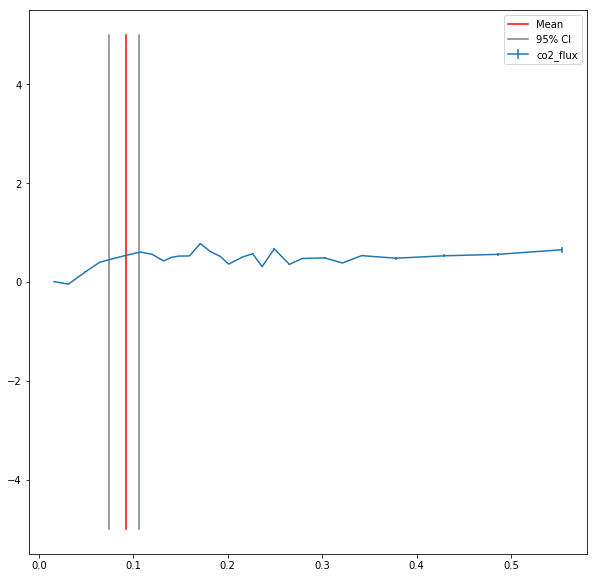

In [475]:
Comp.ustar_Bins(30,{'Var':'PPFD_Avg','Thresh':10},{'Repetitions':100,'n_samples':10000})

# Samp = resample(Comp.uFilterData,replace=True,n_samples=10000)

# print(Comp.BootStraps)

# print(Comp.uFilterData)
Var = 'co2_flux'

Grp = Comp.uFilterData.groupby(['u*bin']).mean()
GrpS = Comp.uFilterData.groupby(['u*bin']).std()
plt.figure(figsize=(10,10))
plt.errorbar(Grp['u*'],Grp[Var],yerr=GrpS['u*']*1.96)

Ratios=[]
for G in Grp.index:
    m1 = Grp[Var][Grp.index==G].values[0]
    m2 = Grp[Var][Grp.index>G].mean()
    Ratios.append(m1/m2)
Ratios = np.asanyarray(Ratios)
Thresh = (Grp.index[np.where(Ratios>=.95)[0]][0])



Ge = []
for i in Comp.BootStraps:
    ge = []
    G = Comp.BootStraps[i].groupby(['u*bin']).mean()
    for g in G.index:
        m1 = G[Var][G.index == g].values[0]
        m2 = G[Var][G.index>g].mean()
        ge.append(m1/m2)
    ge = np.asanyarray(ge)
    try:
        Ge.append(G.index[np.where(ge>=.95)[0]][0])
    except:
        print('Could not find value')
        Ge.append(0.1)
# print(Ge)

print(np.percentile(Ge,[5,50,95]))

print(Thresh)

Val = np.zeros(shape=3)+Thresh
Val_5 = np.zeros(shape=3)+np.percentile(Ge,[5])
Val_50 = np.zeros(shape=3)+np.percentile(Ge,[50])
Val_95 = np.zeros(shape=3)+np.percentile(Ge,[95])
Val_U = np.arange(-5,5.1,5)
plt.plot(Val,Val_U,color = 'red',label='Mean')
plt.plot(Val_5,Val_U,color='grey',label='95% CI')
# plt.plot(Val_50,Val_U)
plt.plot(Val_95,Val_U,color='grey')
# plt.ylim(-.01,.09)
plt.legend()

# Reg = Comp.uFilterData[['u*','AirTC_Avg']].dropna()
# print(stats.linregress(Reg['u*'].values,Reg['AirTC_Avg'].values))
# for i in Grp.index:
#     print(Grp['ch4_flux'][Grp.index==i]/Grp['ch4_flux'][Grp.index>i].mean())

In [466]:
class Compile:
    def __init__(self,Flux_Paths,Met,Soil):
        self.Fluxes = ['H','LE','co2_flux','co2_flux']
        Flux_10 = self.Format(pd.read_csv(Flux_Paths[0],delimiter = ',',skiprows = 0,parse_dates={'datetime':[1,2]},header = 1,na_values = -9999),v=1,drop = [0,1])
        Flux_1 = self.Format(pd.read_csv(Flux_Paths[1],delimiter = ',',skiprows = 0,parse_dates={'datetime':[1,2]},header = 1,na_values = -9999),v=1,drop = [0,1])
#         Flux_10.fillna(Flux_Fill)
        Flux_10['Hz']=10
        Flux_1['Hz'] = 1
        Flux = Flux_1.append(Flux_10)
        Met = self.Format(pd.read_csv(Met,delimiter = ',',skiprows = 1,parse_dates={'datetime':[0]},header = 0),v=2,drop = [0])
        Soil = self.Format(pd.read_csv(Soil,delimiter = ',',skiprows = 0,parse_dates={'datetime':[0]},header = 0),v=0,drop = [0])

        self.RawData = pd.concat([Flux,Met,Soil],axis = 1, join = 'outer')        
        for var in self.Fluxes:
            self.RawData[var+'_drop'] = 0
        
        self.RawData['Minute'] = self.RawData.index.hour*60+self.RawData.index.minute
        self.Wind_Bins(30)
        self.PPFD_Bins(100)
        self.RawData['Day'] = np.floor(self.RawData['DOY'])
        
        Mt = pytz.timezone('US/Mountain')
        self.RawData['UTC'] = self.RawData.index.tz_localize(pytz.utc).tz_convert(Mt)
        self.Rain_Check([.5,0])

    def Format(self,df,v,drop):
        df = df.ix[v:]
        df = df.set_index(pd.DatetimeIndex(df.datetime))
        df = df.drop(df.columns[drop],axis=1)
        df = df.astype(float)
        return(df)
    
    def Date_Drop(self,Date,Vars):
        if Vars == 'All':
            self.RawData = self.RawData.drop(self.RawData.loc[(self.RawData.index>Date[0])&(self.RawData.index<Date[1])].index)
        else:
            self.RawData.loc[(self.RawData.index>Date[0])&(self.RawData.index<Date[1]),[Vars]]=np.nan
        
    def Wind_Bins(self,Bins):
        self.bins = np.arange(0,360.1,Bins)
        self.RawData['Dir'] = pd.cut(self.RawData['wind_dir'],bins=self.bins,labels = (self.bins[0:-1]+self.bins[1:])/2)
        
    def ustar_Bins(self,Bins,LightFilter = {'Var':'PPFD_Avg','Thresh':10},
                   BootStraps={'Repetitions':100,'n_samples':10000}):
        self.uFilterData = self.RawData[self.RawData[LightFilter['Var']]<=LightFilter['Thresh']]
        self.bins = self.uFilterData['u*'].quantile(np.arange(0,Bins,1)/Bins).values
        self.uFilterData['u*bin'] = pd.cut(self.uFilterData['u*'],bins=self.bins,labels = (self.bins[0:-1]+self.bins[1:])/2)
        self.BootStraps = {}
        for i in range(BootStraps['Repetitions']):
            Samp = resample(self.RawData,replace=True,n_samples=BootStraps['n_samples'])
            Samp = Samp[Samp[LightFilter['Var']]<=LightFilter['Thresh']]
            bins = Samp['u*'].quantile(np.arange(0,Bins,1)/Bins).values
            Samp['u*bin'] = pd.cut(Samp['u*'],bins=bins,labels = (bins[0:-1]+bins[1:])/2)
            self.BootStraps[str(i)] = Samp
            
        
#     def BootStrapping()
        
    def PPFD_Bins(self,Bins):
        self.bins = np.arange(0,self.RawData['PPFD_Avg'].max()+1,Bins)
        self.RawData['Photon_Flux'] = pd.cut(self.RawData['PPFD_Avg'],bins=self.bins,labels = (self.bins[0:-1]+self.bins[1:])/2)

    def Rain_Check(self,thresh):
        self.RawData['Rain_diff'] = self.RawData['Rain_mm_Tot'].diff()
        for var in self.Fluxes:
            if var!='ch4_flux':
                self.RawData.loc[self.RawData['Rain_mm_Tot']>thresh[0],[var,var+'_drop']]=[np.nan,1]
            else:
                self.RawData.loc[self.RawData['Rain_mm_Tot']>thresh[1],[var,var+'_drop']]=[np.nan,1]
        
    def Spike_Removal(self,z_thresh,AltData=None):
        if AltData == None:
            for var in self.Fluxes:
                series = self.RawData[var].dropna()
                di1 = series.diff()
                di1[:-1] = di1[1:]
                di = di1.diff()
                MD = di.median()
                MAD = np.abs(di-MD).median()
                F1 = di<MD-(z_thresh*MAD/0.6745)
                F2 = di>MD+(z_thresh*MAD/0.6745)
                series.loc[F1==True]=np.nan
                series.loc[F2==True]=np.nan
                Droppers = series.index[np.isnan(series)==True]
                VAR = self.RawData[var]
                VAR.ix[Droppers] = np.nan
                dina = VAR.diff()
                dina[:-1] = dina[1:]
                dina2 = VAR.diff()
                NaMid = VAR.index[((np.isnan(dina)==True)&(np.isnan(dina2)==True))]
                VAR.ix[NaMid] = np.nan
                self.RawData[var] = VAR
        else:
            series = AltData[0][AltData[1]].dropna()
            di1 = series.diff()
            di1[:-1] = di1[1:]
            di = di1.diff()
            MD = di.median()
            MAD = np.abs(di-MD).median()
            F1 = di<MD-(z_thresh*MAD/0.6745)
            F2 = di>MD+(z_thresh*MAD/0.6745)
            series.loc[F1==True]=np.nan
            series.loc[F2==True]=np.nan
            Droppers = series.index[np.isnan(series)==True]
            VAR = self.RawData[var]
            VAR.ix[Droppers] = np.nan
            dina = VAR.diff()
            dina[:-1] = dina[1:]
            dina2 = VAR.diff()
            NaMid = VAR.index[((np.isnan(dina)==True)&(np.isnan(dina2)==True))]
            VAR.ix[NaMid] = np.nan
            AltData[0][AltData[1]] = VAR
            return(AltData[0])
        
    def Wind_Filter(self,width):
        for var in self.Fluxes:
            self.RawData.loc[((self.RawData['wind_dir']>215-width)&(self.RawData['wind_dir']<215+width)),[var,var+'_drop']]=[np.nan,1]
        
    def StorageCorrection(self):
        self.RawData['fco2'] = self.RawData['co2_flux']+self.RawData['co2_strg']
        self.RawData['fch4'] = self.RawData['ch4_flux']+self.RawData['ch4_strg']
        
    def Process(self,qc_thresh=None,rain_thresh=None,ch4_signal_thresh=None,spike_thresh=None,wind_drop=None,U_thresh=None):
        self.Data = self.RawData.copy()
#         self.Date_Drop('2017-06-23 15:00:00')
        if qc_thresh!=None:
            self.QC_Check(qc_thresh)
        if ch4_signal_thresh!=None:
            self.Signal_Check(ch4_signal_thresh)
        self.NAN_Check()
    
    def QC_Check(self,thresh):
        for var in self.Fluxes:
            self.Data[var+'_drop'] = 0
            self.Data.loc[self.Data['qc_'+var]>=thresh,[var,var+'_drop']]=[np.nan,1]
            
        
    def Ustar_Check(self,U_thresh):
        for var in self.Fluxes:
            self.Data.loc[self.Data['u*']<U_thresh,[var,var+'_drop']]=[np.nan,1]
        
            
    def Signal_Check(self,thresh):
        self.Data['ch4_noSSFilter'] = self.Data['ch4_flux']
        self.Data.loc[self.Data['rssi_77_mean']<thresh,['ch4_flux','ch4_flux_drop']] = [np.nan,1]
                              
    def NAN_Check(self):
        for var in self.Fluxes:
            self.Data.loc[np.isnan(self.Data[var]) == True,[var+'_drop']]=1

## Initialize everything and parse the data
Comp = Compile([TenHz_Path,OneHz_Path],Met_Path,Soil_Path)

Drop = [['2017-06-01 15:00:00','2017-06-23 15:00:00'],
['2017-08-28 00:00:00','2017-09-11 16:00:00'],
['2017-09-12 07:30:00','2017-09-12 15:00:00']]
Var = ['All','co2_flux','co2_flux']
for drop,var in zip(Drop,Var):
    Comp.Date_Drop(drop,Vars=var)
Comp.Spike_Removal(z_thresh=4)
Comp.Wind_Filter(30)
Comp.StorageCorrection()


In [391]:
## Remove unwanted Data
# Comp.
# Process(Data,qc_thresh=2,rain_thresh=[.5,0],ch4_signal_thresh=10,spike_thresh=4,wind_drop = 30,U_thresh=.1)
## Determine u* threshold
Comp.Ustar_thresh_calc(Var = 'ch4_flux',NightThresh=20)



In [392]:

# print(Grp['ch4_flux'])

# from scipy.optimize import curve_fit

# # def Sigmoid(x,a,b):
# #     return(a*((1+np.exp(-x)))+b)


# # def SquareRoot(x,a,b,c):
# #     return(a*x**b+c)

# # print(Q)
    
# #     print(Data.loc[Data['AirTC_Avg']<=q][['AirTC_Avg','TempClass']].head(5))
# #     print()
# # print(Data['AirTC_Avg'])
# plt.plot(Data['uClass'])
# # Data=Comp.RawData[['u*','ch4_flux']].dropna()

# # popt, pcov = curve_fit(SquareRoot, Data['u*'].values, Data['ch4_flux'].values)

# # print(popt,pcov)

# # # plt.figure(figsize=(10,10))
# # # plt.plot(Comp.RawData['co2_flux'].resample('D').mean()*3.6,linewidth=10,color='red')
# # # plt.plot(Comp.Data['co2_flux'].resample('D').mean()*3.6,linewidth=4,color='green')


# # plt.figure(figsize=(10,10))
# # plt.scatter(Comp.RawData['u*'],Comp.RawData['ch4_flux'])
# # plt.ylabel('CH4 Flux')
# # plt.xlabel('u*')
# # # plt.xlim(-.01,.4)

# # Ten = np.arange(0,10,.01)

# # # plt.plot(Ten,   popt[0]*(1/(1+np.exp(-Ten)))+popt[1]    )
# # plt.plot(Ten,popt[0]*Ten**popt[1]+popt[2])

In [376]:
# print(Comp.RawData['TempClass'])
plt.figure(figsize=(10,10))

U_tresh = []
for t in Comp.RawData['TempClass'].unique():
    Cl = []
    Vr = []
    Vm = []
    if np.isnan(t)!=True:
        Valz = Comp.RawData[['u*','AirTC_Avg']][(Comp.RawData['TempClass']==t)].dropna().values
        lr = stats.linregress(Valz[:,0],Valz[:,1])
        print(lr[2])
        if np.abs(lr[2])<.4:
            for u in np.sort(Comp.RawData['uClass'].unique()):
                if np.isnan(u)!=True:
                    m1 = Comp.RawData['ClassMean'][((Comp.RawData['TempClass']==t)&(Comp.RawData['uClass']==u))].unique()
                    m2 = Comp.RawData['ClassMean'][((Comp.RawData['TempClass']==t)&(Comp.RawData['uClass']>u))].unique()#.mean()
                    c = Comp.RawData['uClass_Val'][((Comp.RawData['TempClass']==t)&(Comp.RawData['uClass']==u))].mean()
                    if np.isnan(m2.mean()) == True:
                        m2=m1

                    Cl.append(Comp.RawData['uClass_Val'][((Comp.RawData['TempClass']==t)&(Comp.RawData['uClass']==u))].mean())
                    Vr.append(m1/m2.mean())
                    Vm.append(m2.mean())
    #                 print(m1/m2.mean())
    #                 print(c)
    #                 print(m1,m2)
    #                 print()
                
            Cl = np.asanyarray(Cl)
            Vr = np.asanyarray(Vr)
            Vm = np.asanyarray(Vm)
#             print(Vr)
#             print(np.where(Vr>=.95))
            U_tresh.append(Cl[np.where(Vr>=.95)[0]][0])
    #         print(Cl,Vr,Vm)
            plt.plot(Cl,Vr,label=lr[2])
            plt.scatter(Cl,Vm,label=lr[2])
# plt.ylim(.75,1.25)
U_tresh=np.asanyarray(U_tresh)
# print()
# print(np.median(U_tresh))
plt.grid()
plt.legend()




Valz = Comp.RawData[['u*','AirTC_Avg']].dropna().values
lr = stats.linregress(Valz[:,0],Valz[:,1])
# print(lr)
# plt.figure(figsize=(10,10))
# plt.scatter(Comp.RawData.index,2.83/Comp.RawData['L'])
# plt.ylim(0,.1)
# plt.figure(figsize=(10,10))
# # plt.scatter(Comp.RawData['u*'][Comp.RawData['NR_Wm2_Avg']<20],Comp.RawData['co2_flux'][Comp.RawData['NR_Wm2_Avg']<20])
# plt.scatter(Comp.RawData['u*'][Comp.RawData['PPFD_Avg']<1e3],Comp.RawData['ch4_flux'][Comp.RawData['PPFD_Avg']<1e3])
# plt.grid()

# print(Comp.RawData['u*bin'])


# print(Comp.RawData['u*'][Comp.RawData['PPFD_Avg']<10].count()/Comp.RawData['u*'].count())

KeyError: 'TempClass'

In [ ]:
def Scatter(Var,xl=None,yl=None):
    plt.figure(figsize=(7,7))
    plt.scatter(Fix[Var],NoFix[Var])
    plt.xlabel('Fix')
    plt.ylabel('NoFix')
    if xl!=None:
        plt.xlim(xl[0],xl[1])
        plt.ylim(yl[0],yl[1])
    plt.title(Var)

# Scatter('Wind')
# # Scatter('u*')
# Scatter('co2_strg',[-2,2],[-2,2])
# Scatter('qc_co2_flux')#,[-5,5],[-5,5])

plt.figure(figsize=(15,10))
plt.legend()
# Scatter('H')
# Scatter('LE')


In [ ]:
# plt.figure(figsize=(10,10))


for root,Dir,files in (os.walk(Root+'TagluStationData/Daily/')):
    for i,file in enumerate(files):
        print(files,i)
        df = pd.read_excel(root+file,sheetname=[0],skiprows=[0,2,3])[0]
#         print(df.head())
        df = df.set_index(pd.DatetimeIndex(df.TIMESTAMP))
        if i == 0:
            Daily = df
        else:
            Daily = Daily.append(df)
#         df=df.resample('D').max()
#         plt.plot(Hourly.index.dayofyear,Hourly['WindSpd']*3.6,color=(0,0,0,.5))
#         plt.xlim(190,260)


for root,Dir,files in (os.walk(Root+'TagluStationData/Hourly/')):
    for i,file in enumerate(files):
        df = pd.read_excel(root+file,sheetname=[0],skiprows=[0,1,3])[0]
        df = df.set_index(pd.DatetimeIndex(df.TIMESTAMP))
        if i == 0:
            Hourly = df
        else:
            Hourly = Hourly.append(df)
#         df=df.resample('D').mean()
#         plt.plot(df.index.dayofyear,df['WindSpd']*3.6,color=(0,0,0,.75))
#         plt.xlim(190,260)
     
    

# plt.plot(Fix['Wind'].resample('D').mean().index.dayofyear,Fix['Wind'].resample('D').mean(),label='Fix',
#         linewidth=4)
# plt.plot(NoFix['Wind'].resample('D').mean().index.dayofyear,NoFix['Wind'].resample('D').mean(),label='NoFix',
#         linewidth=4)

# plt.ylim(0,30)

# print(Daily.index.dayofyear)
Daily.loc[Daily['Snow_Depth']<0] = np.nan
Daily.loc[Daily['Snow_Depth']>1] = np.nan
Daily['Snow_Depth'].ffill()

In [ ]:
# Monthly = Data.ffill().resample('M').mean()


Daily.loc[Daily['Snow_Depth']<0] = np.nan
Daily.loc[Daily['Snow_Depth']>.7] = np.nan
Daily['Snow_Depth'].ffill()

Data=Hourly.resample('D').mean()
Data=Data.groupby(Data.index.dayofyear).mean()
DailyData=Daily.groupby(Daily.index.dayofyear).mean()
# print(Monthly)

# print(Daily.head())

fig,ax = plt.subplots(2,2,figsize=(10,10))

ax1 = ax[0,0]
ax2 = ax[0,1]
ax3 = ax[1,0]
ax4 = ax[1,1]

ax1.plot(Data['AirTemp'])
ax1.grid()


ax2.plot(Data['Net_Ttl_Rad_Avg'])
ax2.grid()

ax3.plot(DailyData['WindSpd']*3.6)
# ax3.set_ylim(0,1)
ax3.grid()

ax4.plot(Data['SoilMoist(3)'])
ax4.grid()

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(Daily['Snow_Depth'])